In [2]:
!unzip -q /content/stage1_train.zip -d /content/dataset
print("Unzipping done!")

Unzipping done!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp -r /content/dataset /content/drive/MyDrive/U-Net_Project_Dataset
print("Dataset copied to Drive successfully!")

Dataset copied to Drive successfully!


**Set Dataset Path for Training**

In [3]:
DATASET_PATH = "/content/drive/MyDrive/U-Net_Project_Dataset"
print("Dataset Path:", DATASET_PATH)

Dataset Path: /content/drive/MyDrive/U-Net_Project_Dataset


**Load Image + Merge All Masks**

In [4]:
import os
import numpy as np
import cv2

IMG_SIZE = 128

def load_stage1_dataset(dataset_path):
    images = []
    masks = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        img_folder = os.path.join(folder_path, "images")
        mask_folder = os.path.join(folder_path, "masks")

        # Load Image
        img_file = os.listdir(img_folder)[0]
        img_path = os.path.join(img_folder, img_file)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # Merge All Masks into One
        merged_mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)

        for mask_file in os.listdir(mask_folder):
            mask_path = os.path.join(mask_folder, mask_file)

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
            mask = mask / 255.0

            merged_mask = np.maximum(merged_mask, mask)

        merged_mask = np.expand_dims(merged_mask, axis=-1)

        images.append(img)
        masks.append(merged_mask)

    return np.array(images), np.array(masks)


**Run Loader**

In [6]:
X, Y = load_stage1_dataset(DATASET_PATH)

print("Images Shape:", X.shape)
print("Masks Shape :", Y.shape)

Images Shape: (670, 128, 128, 3)
Masks Shape : (670, 128, 128, 1)


**Visualize Sample**

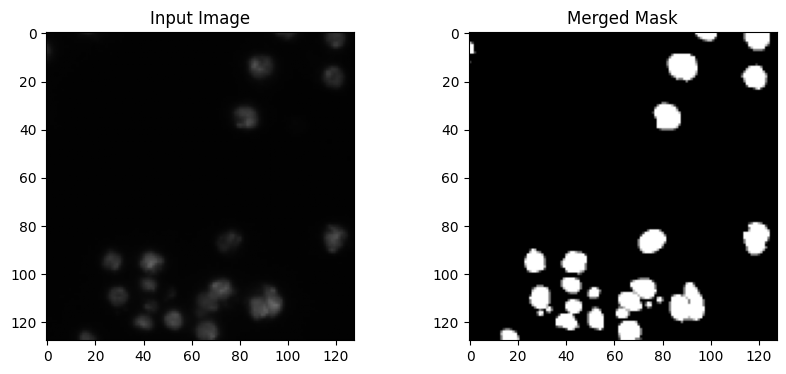

In [7]:
import matplotlib.pyplot as plt

index = 0

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(X[index])
plt.title("Input Image")

plt.subplot(1,2,2)
plt.imshow(Y[index].squeeze(), cmap="gray")
plt.title("Merged Mask")

plt.show()


**Train/Test Split**

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

**Build Full Proper U-Net Model**

In [9]:
from tensorflow.keras import layers, Model

def build_unet(input_shape=(128,128,3)):

    inputs = layers.Input(input_shape)

    # ---------- Encoder ----------
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, 3, activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, 3, activation="relu", padding="same")(c4)

    # ---------- Decoder ----------
    u5 = layers.UpSampling2D()(c4)
    u5 = layers.Concatenate()([u5, c3])
    c5 = layers.Conv2D(256, 3, activation="relu", padding="same")(u5)
    c5 = layers.Conv2D(256, 3, activation="relu", padding="same")(c5)

    u6 = layers.UpSampling2D()(c5)
    u6 = layers.Concatenate()([u6, c2])
    c6 = layers.Conv2D(128, 3, activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, 3, activation="relu", padding="same")(c6)

    u7 = layers.UpSampling2D()(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, 3, activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, 3, activation="relu", padding="same")(c7)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c7)

    return Model(inputs, outputs)


**Create Model**

In [10]:
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 768)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,769,728 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 7,782,913 (29.69 MB)

 Trainable params: 7,782,913 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

**Compile Model**

In [11]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

**Train Model**

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=5,
    batch_size=8
)

Epoch 1/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 862s 13s/step - accuracy: 0.7913 - loss: 0.5578 - val_accuracy: 0.8644 - val_loss: 0.2640
Epoch 2/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 884s 13s/step - accuracy: 0.8578 - loss: 0.2463 - val_accuracy: 0.9224 - val_loss: 0.1608
Epoch 3/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 878s 13s/step - accuracy: 0.9092 - loss: 0.1872 - val_accuracy: 0.9401 - val_loss: 0.1211
Epoch 4/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 832s 12s/step - accuracy: 0.9307 - loss: 0.1383 - val_accuracy: 0.9422 - val_loss: 0.1099
Epoch 5/5
67/67 ━━━━━━━━━━━━━━━━━━━━ 853s 13s/step - accuracy: 0.9390 - loss: 0.1197 - val_accuracy: 0.9458 - val_loss: 0.1011


**Plot Training History**

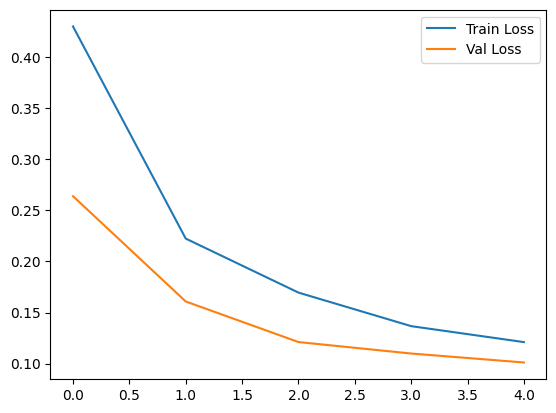

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.show()


**Predict on Test Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


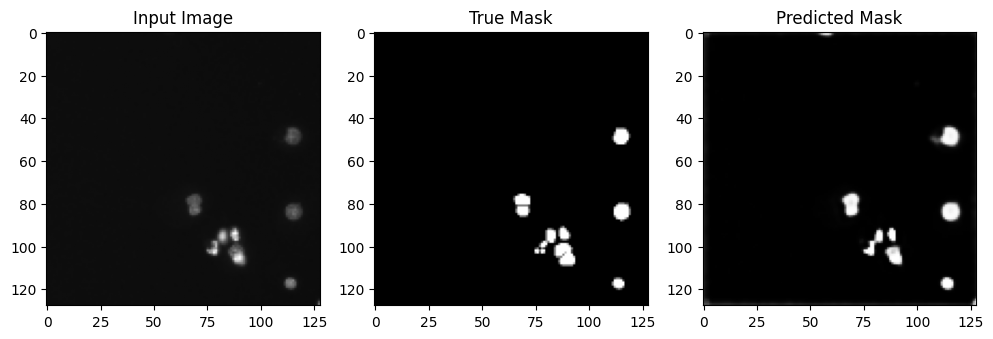

In [14]:
index = 0

pred = model.predict(X_test[index:index+1])[0]

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(X_test[index])

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(Y_test[index].squeeze(), cmap="gray")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred.squeeze(), cmap="gray")

plt.show()


**Save Model**

In [15]:
model.save("/content/drive/MyDrive/unet_stage1_model.h5")
print("Model Saved Successfully in Drive!")

Model Saved Successfully in Drive!


**Save Training History**

In [16]:
import pandas as pd

df = pd.DataFrame(history.history)
df.to_csv("/content/drive/MyDrive/unet_training_history.csv", index=False)

print("Training history saved!")


Training history saved!
